In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
from numpy.linalg import cond, norm, inv

import pandas as pd
from scipy.stats import linregress as linreg
import scipy.sparse.linalg as spla

import pickle
import os.path
import itertools

from poly_basis import *
from rbf import *
from spherepts import *
from torus_points import *
from laplacebeltrami import *

from ex006_helpers import *

In [2]:
matplotlib.rcParams.update({'font.size': 20})

# Parameters

In [12]:
if False: # sphere
    surface = 'S'

    # node_sets = ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
    # node_sets = ['icos', 'spiral']
    node_sets = ['spiral']
    
    foo, exact = get_exact('gaussians')
    # foo, exact = get_exact(10)
    
else: # torus
    surface = 'T'
    node_sets = ['phyllotaxis']
    


methods = ['SWM', 'TPM', 'SOGr']
# methods = ['TPM', 'SOGr']
# methods = ['SWM']

# ns = [500* 2**i for i in range(2,8)]
ns = [2000 * 2**i for i in range(1, 5)]
# ns = [100 * 2**i for i in range(6)]
# ns = [100]
# ns = [25600]

# stencil_sizes = [10 * 2**i for i in range(7)] #+ [800]
stencil_sizes = [100]

# rbfs = ['multiquadric', 'r^10 log(r)', 'gaussian', 'r^9']
# rbfs = ['r^8 log(r)', 'r^10 log(r)', 'r^12 log(r)', 'r^14 log(r)', 'r^14 log(r)', 'r^16 log(r)', 'r^18 log(r)']
# rbfs = ['r^9', 'r^11', 'r^13', 'r^15', 'r^17']
# rbfs = ['multiquadric']
rbfs = ['r^10 log(r)']

epsilons = [None]
# epsilons = [1.41984]
#epsilons = [1, .5, .25, .1, .05]

basis_degs = [4, 5] # -1 for no terms
# basis_degs = [0, 2, 4]
# basis_degs = range(-1, 6)
#basis_degs = range(-1,2) # -1 for no terms
basis_types = ['p']
# basis_types = ['p']

rcond = 1e-12

eig_calc = False


# calculate_weights_cond = False
# calculate_stencil_conds = True
# calc_largest_real_eig = True 


# Print Specs
sep = 22
print('Methods:'.ljust(sep)            + ', '.join(methods))
print('Surface:'.ljust(sep)            + surface)
print('Node sets:'.ljust(sep)          + ', '.join(node_sets))
print('Total Nodes:'.ljust(sep)        + ', '.join([str(n) for n in ns]))
print('Stencil Sizes:'.ljust(sep)      + ', '.join([str(k) for k in stencil_sizes]))
print('RBFs:'.ljust(sep)               + ', '.join(rbfs))
print('Epsilons:'.ljust(sep)           + ', '.join([str(e) for e in epsilons]) )
print('Polynomial Bases:'.ljust(sep)   + ', '.join(basis_types))
print('Polynomial Degrees:'.ljust(sep) + ', '.join([str(d) for d in basis_degs]))
print('rcond = %g' % rcond)

trials = 1
trials *= len(methods)
trials *= len(node_sets)
trials *= len(ns)
trials *= len(stencil_sizes)
trials *= len(rbfs)
trials *= len(epsilons)
trials *= len(basis_types)
trials *= len(basis_degs)

print('\nTrials to run: %d' % trials)

Methods:              SOGr, SWM, TPM
Surface:              T
Node sets:            phyllotaxis
Total Nodes:          4000, 8000, 16000, 32000
Stencil Sizes:        100
RBFs:                 r^10 log(r)
Epsilons:             None
Polynomial Bases:     p
Polynomial Degrees:   4, 5
rcond = 1e-12

Trials to run: 24


# Generate Data

In [13]:
columns = ['surface', 'nodeset', 'N', 'k', 'method', 'rbf', 'epsilon', 'poly_type', 'deg',
           'rel_L2_error', 'max_error', 'Re_eig']
data = pd.DataFrame(columns=columns)

for node_set, n in itertools.product(node_sets, ns):
    if surface is 'S':
        n_try = n
        n, nodes = gen_sphere_nodes(node_set, n_try)
        normals = nodes
        print('\n' + node_set + ' n=' + str(n))
        fs = np.array([foo(node) for node in nodes])
        ds = np.array([exact(node) for node in nodes])
    elif surface is 'T':
        nodes, normals = torus_phyllotaxis_points(n)
        print('\n' + node_set + ' n=' + str(n))
        fs, ds = torus_forcing(nodes)

    for k, rbf in itertools.product(stencil_sizes, rbfs):
        print(('\t' + rbf.ljust(14)) + 'k=' + str(k).rjust(4))
        rbf_obj = rbf_dict[rbf]
        
        for method in methods:
            for poly_type, poly_deg in itertools.product(basis_types, basis_degs):
                if method is 'TPM' and poly_type is 's': continue
                print('\t    ' + method +'  ' + poly_type + '  d=' + str(poly_deg).rjust(2))
                for eps in epsilons:
                    if rbf_obj['shape']:
                        print('\t\t epsilon = %s' % str(eps))
                    ##################################################
                    # calculate weights and errors
                    ##############################
                    if poly_deg is -1:
                        poly_deg = None
                    try:
#                     if True:
                        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                                    eps, poly_type, poly_deg, rcond)
                        rel_error_L2  = la.norm(C@fs - ds)/la.norm(ds)
                        rel_error_max = np.max(np.abs(C@fs - ds))/np.max(np.abs(ds))
                        print('\t\t  relative L2  error: %g' % rel_error_L2)
                        print('\t\t  relative Max error: %g' % rel_error_max)
                        if eig_calc:
                            eig = spla.eigs(C, k=1, which='LR')[0][0].real
                        else:
                            eig = None
                        data = data.append( 
                            {'method': method, 'surface': surface,
                             'nodeset': node_set, 'rbf':rbf, 'epsilon': eps,
                             'deg': str(poly_deg), 'poly_type' : poly_type,
                             'N':n, 'k':k,
                             'max_error': rel_error_max, 
                             'rel_L2_error': rel_error_L2,
                             'Re_eig' : eig,
                             }, ignore_index=True)
                    except:
                        print('\t\t  Failed...')
                    
                    
                    ##################################################
                    # end calculate weights and errors
                    ##################################################
                    if not rbf_obj['shape']: break
    


phyllotaxis n=4000
	r^10 log(r)   k= 100
	    SOGr  p  d= 4
		  relative L2  error: 0.0107133
		  relative Max error: 0.0575367
	    SOGr  p  d= 5
		  relative L2  error: 0.000192518
		  relative Max error: 0.000219249
	    SWM  p  d= 4
		  relative L2  error: 2.36849
		  relative Max error: 12.5848
	    SWM  p  d= 5
		  relative L2  error: 0.000726504
		  relative Max error: 0.000873926
	    TPM  p  d= 4
		  relative L2  error: 0.000523052
		  relative Max error: 0.00045508
	    TPM  p  d= 5
		  relative L2  error: 0.000524138
		  relative Max error: 0.000456347

phyllotaxis n=8000
	r^10 log(r)   k= 100
	    SOGr  p  d= 4
		  relative L2  error: 7.82208e-05
		  relative Max error: 0.000117768
	    SOGr  p  d= 5
		  relative L2  error: 5.087e-05
		  relative Max error: 7.7248e-05
	    SWM  p  d= 4
		  relative L2  error: 0.000260651
		  relative Max error: 0.000249363
	    SWM  p  d= 5
		  relative L2  error: 0.000195997
		  relative Max error: 0.000278302
	    TPM  p  d= 4
		  relati

# Raw Data

In [15]:
if len(data)<20:
    display(data)
if len(data)<50:
    display(data[::2])
elif len(data)< 100:
    display(data[::7])
elif len(data)< 500:
    display(data[::11])
elif len(data)<1000:
    display(data[::51])
else:
    display(data[:5000:100])

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
0,T,phyllotaxis,4000,100,SOGr,r^10 log(r),None,p,4,0.010713,0.057537,None
2,T,phyllotaxis,4000,100,SWM,r^10 log(r),None,p,4,2.368489,12.584834,None
4,T,phyllotaxis,4000,100,TPM,r^10 log(r),None,p,4,0.000523,0.000455,None
6,T,phyllotaxis,8000,100,SOGr,r^10 log(r),None,p,4,0.000078,0.000118,None
8,T,phyllotaxis,8000,100,SWM,r^10 log(r),None,p,4,0.000261,0.000249,None
10,T,phyllotaxis,8000,100,TPM,r^10 log(r),None,p,4,0.000108,0.000103,None
12,T,phyllotaxis,16000,100,SOGr,r^10 log(r),None,p,4,0.000012,0.000018,None
14,T,phyllotaxis,16000,100,SWM,r^10 log(r),None,p,4,0.000048,0.000071,None
16,T,phyllotaxis,16000,100,TPM,r^10 log(r),None,p,4,0.000020,0.000020,None
18,T,phyllotaxis,32000,100,SOGr,r^10 log(r),None,p,4,0.000003,0.000004,None


In [6]:
display(data[(data.method=='SWM') & (data.deg=='5')])

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
1,S,spiral,2000,100,SWM,r^10 log(r),None,p,5,0.000057,0.000054,-6.181586e-08
7,S,spiral,4000,100,SWM,r^10 log(r),None,p,5,0.000019,0.000021,-6.683869e-08
13,S,spiral,8000,100,SWM,r^10 log(r),None,p,5,0.000028,0.000130,-1.994939e-07
19,S,spiral,16000,100,SWM,r^10 log(r),None,p,5,0.000042,0.000164,-4.259407e-07
25,S,spiral,32000,100,SWM,r^10 log(r),None,p,5,0.000091,0.000328,-2.862222e-08


# Plots

In [16]:
method_abrv = {'SWM': 'IRBF-FD', 'TPM': 'TPM', 'SOGr': 'HRBF-FD'}

### By Degree - (Method, RBF, polytype, k)

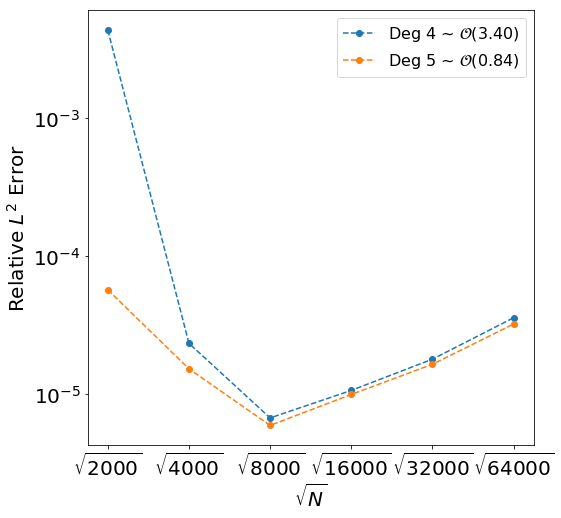

In [49]:
# degs = [str(d) for d in range(0,6)]

rbf = 'r^10 log(r)'
method = 'SWM'
poly_type = 'p'
k = 100

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
if method is 'SWM':
    title += 'Projection Method using '
elif method is 'TPM':
    title += 'Tangent Plane Method using '
elif method is 'SOGr':
    title += 'Hermite RBF-FD using '
rbf_obj = rbf_dict[rbf]
title += '$\phi(r)=$' + rbf_obj['tex']
if poly_type is 'p':
    title += '\nappended with polynomials, '
else:
    title += '\nappended with spherical harmonics, '
title += ('k=%d' % k)

my_data = data[(data.method==method) & (data.rbf==rbf) & (data.poly_type==poly_type) & (data.k==k)]
fig = plt.figure(figsize=(8,8))
legend = []
for i, deg in enumerate(my_data.deg.unique()):
# for i, deg in enumerate(degs):
    plot_data = my_data[my_data.deg==str(deg)]
    plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
               plot_data.rel_L2_error, marker='o', linestyle='dashed')
    order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += ['Deg ' + deg + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
# plt.title(title)
plt.legend( legend , prop={'size': 16})
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By Method - (RBF, d, k)

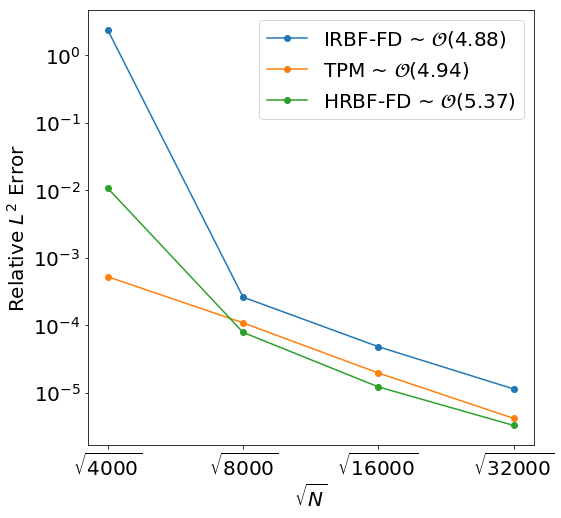

In [26]:
rbf = 'r^10 log(r)'
d = '4'
k = 100
poly_type = 'p'
# nodeset = 'spiral'
nodeset = data.nodeset.unique()[0]
show_order = True
order_lines = [3, 4]
#highest_N = 32000

# Order calculation terms
o_start = 1
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += (' with degree %s polynomials\n' % d)
title += ('stencil size = %d points' % k)

my_data = data[(data.deg==d) & (data.rbf==rbf) & (data.k==k) & (data.nodeset==nodeset)]
# if highest_N is not None:
#     my_data = my_data[my_data.N.astype(np.float)<=highest_N]
fig = plt.figure(figsize=(8,8))
legend = []
# for i, method in enumerate(my_data.method.unique()):
for i, method in enumerate(['SWM', 'TPM', 'SOGr']):
    
    for poly_type, linestyle, marker in zip('ps', ['-','--'], 'ox'):
        plot_data = my_data[(my_data.method==method) & (my_data.poly_type==poly_type)]
        if len(plot_data)<1: continue
        plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker='o', linestyle='-')
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        if show_order:
            legend += [(method_abrv[method]) + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
        else:
            legend += [(method_abrv[method])]
        
#smallest N
# num_N = len(my_data.N.unique())-1
# my_N = min(my_data.N.unique())
# err_high = max(my_data[my_data.N==my_N]['rel_L2_error']) * 1.1
# err_low  = min(my_data[my_data.N==my_N]['rel_L2_error']) * .1
# for order, err_start, shift in zip(order_lines, [err_high,err_low], [1.2,.9]):
#     err_end = err_start*2**(-(num_N-1)/2*order)
#     plt.loglog([np.sqrt(my_N), np.sqrt(my_N*2**(num_N-1))], [err_start, err_end], 'k--')
#     plt.text(np.sqrt(my_N*2**(num_N-1)), err_end*shift, '$\mathcal{O}(%d)$'%order)
    
    
# plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%s}$' % n for n in ns])
# plt.xticks(np.sqrt(ns[:num_N+1]), ['$\sqrt{%s}$' % n for n in my_data.N.unique()])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

In [254]:
num_N

4

In [ ]:
def schur_solve(A, P, f, g):
    lam = la.pinv(P.T @ la.solve(A, P), rcond=1e-10) @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam

In [ ]:
def schur_solve2(A, P, f, g):
    lam = la.pinv(P.T @ la.solve(A, P), rcond=1e-10) @  (P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam

In [193]:
A = (np.arange(25)).reshape((5,5))
P = np.arange(15).reshape((5,3))*1.0
# A[1,1] = 20
print(A)

[[ 0.   0.5  1.   1.5  2. ]
 [ 2.5  3.   3.5  4.   4.5]
 [ 5.   5.5  6.   6.5  7. ]
 [ 7.5  8.   8.5  9.   9.5]
 [10.  10.5 11.  11.5 12. ]]


In [194]:
cond(A)

4.554276642606108e+17

In [172]:
U, S, V = la.svd(A)

In [158]:
U*S@V - A

array([[3.33066907e-16, 2.66453526e-15, 8.88178420e-16],
       [3.10862447e-15, 0.00000000e+00, 2.66453526e-15],
       [8.88178420e-16, 8.88178420e-16, 1.77635684e-15]])

In [159]:
print(U, S, V)

[[-0.06960738  0.14482276 -0.98700617]
 [-0.88738543 -0.46100054 -0.00506056]
 [-0.45574326  0.87550264  0.16060265]] [23.19573313  6.96754184  1.18799206] [[-0.23265554 -0.90566306 -0.35446553]
 [ 0.55543466 -0.42291378  0.71598622]
 [ 0.79835064  0.03030428 -0.60142989]]


In [162]:
A @ V.T* 1/S @ U.T

array([[ 1.00000000e+00, -1.43982049e-16,  1.94289029e-16],
       [ 1.24032729e-16,  1.00000000e+00, -6.39679282e-17],
       [-1.52655666e-15,  3.57786717e-18,  1.00000000e+00]])

In [173]:
print(S)
S[S< 1e-14] = 0 
S[S>0] = 1/S[S>0]
print(S)

[1.42267074e+01 1.26522599e+00 5.89938022e-16]
[0.07029033 0.79037263 0.        ]


In [176]:
(V.T*S)@U.T @ A

array([[ 0.83333333,  0.33333333, -0.16666667],
       [ 0.33333333,  0.33333333,  0.33333333],
       [-0.16666667,  0.33333333,  0.83333333]])

In [146]:
A.T @ A

array([[45., 54., 63.],
       [54., 66., 78.],
       [63., 78., 93.]])

### By RBF

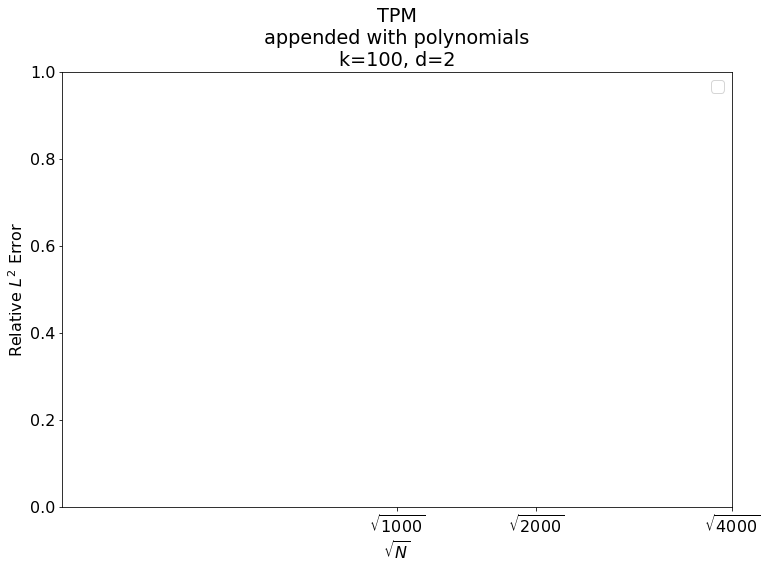

In [10]:
method = 'TPM'
d = '2'
k = 100
poly_type = 'p'
# omit = ['r^9']
omit = []

# Order calculation terms
o_start = 0
o_end = -1
##################################################
title = method + '\n'
rbf_obj = rbf_dict[rbf]
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.method==method) & (data.k==k) & (data.poly_type==poly_type)]
for rbf in omit:
    my_data = my_data[my_data.rbf!=rbf]
fig = plt.figure(figsize=(12,8))
legend = []
for i, rbf in enumerate(my_data.rbf.unique()):
    rbf_obj = rbf_dict[rbf]
    plot_data = my_data[(my_data.rbf==rbf)]
    if len(plot_data)<1: continue
    plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
               plot_data.rel_L2_error, marker='o', linestyle='dashed')
    order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += [rbf_obj['tex'] + ' ~ $\mathcal{O}(%.2f)$' %(-order)]

    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

### By Stencil Size

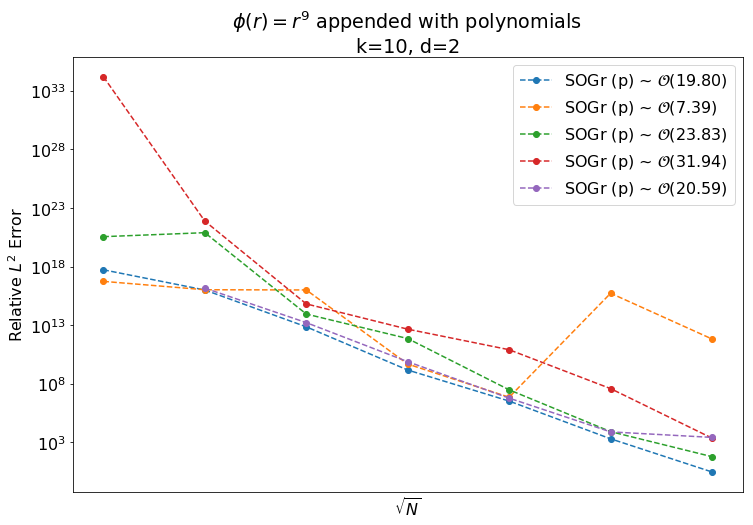

In [24]:
method = 'SOGr'
rbf = 'r^9'
d = '2'

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.rbf==rbf) & (data.method==method)]
fig = plt.figure(figsize=(12,8))
legend = []
for deg in my_data.deg.unique():
    plot_data = my_data[(my_data.deg==deg)]
    if len(plot_data)<1: continue
    plt.loglog( np.sqrt(plot_data.k.astype(np.float)), 
               plot_data.rel_L2_error, 'o--')
    order = linreg(np.log(np.sqrt(plot_data.k[o_start:o_end].astype(np.float))), 
               np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
    legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

In [19]:
display(plot_data)

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
12,S,spiral,800,10,SOGr,multiquadric,None,p,2,0.018075,0.015248,2.842171e-14


### Mixing Methods and Rbfs

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
0,S,spiral,1600,50,SWM,multiquadric,None,p,None,0.000261,0.000181,-5.034726e-05
1,S,spiral,1600,50,SWM,multiquadric,None,p,0,0.000231,0.000185,3.605425e-13
2,S,spiral,1600,50,SWM,multiquadric,None,p,1,0.000237,0.000196,1.023626e-12
3,S,spiral,1600,50,SWM,multiquadric,None,p,2,0.000234,0.000186,1.217385e-14
4,S,spiral,1600,50,SWM,multiquadric,None,p,3,0.000215,0.000192,-1.707361e-12
5,S,spiral,1600,50,SWM,multiquadric,None,p,4,0.000158,0.000139,-1.481110e-11
6,S,spiral,1600,50,TPM,multiquadric,None,p,None,0.000126,0.000103,-3.412607e-05
7,S,spiral,1600,50,TPM,multiquadric,None,p,0,0.000120,0.000114,-9.221965e-14
8,S,spiral,1600,50,TPM,multiquadric,None,p,1,0.000120,0.000110,-1.412688e-14
9,S,spiral,1600,50,TPM,multiquadric,None,p,2,0.000112,0.000091,-3.736313e-15


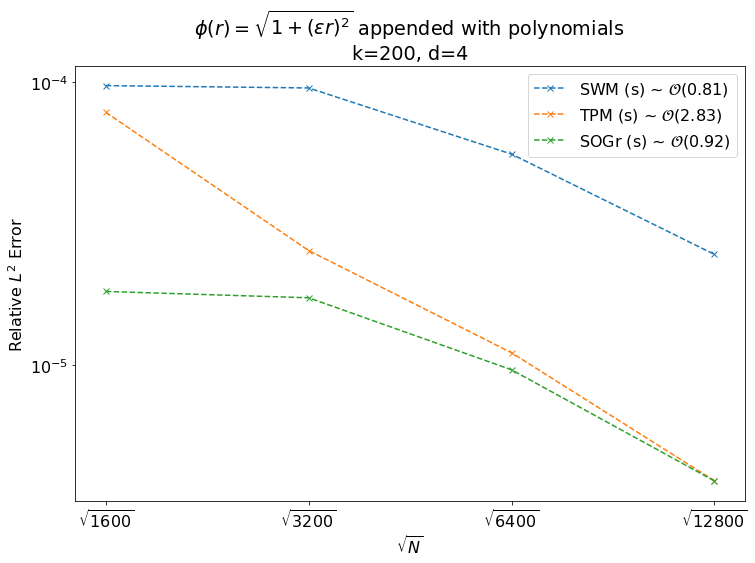

In [57]:
rbf = 'multiquadric'
d = '4'
k = 200

# Order calculation terms
o_start = 0
o_end = -1
##################################################
rbf_obj = rbf_dict[rbf]
title = ''
rbf_obj = rbf_dict[rbf]
title = '$\phi(r)=$' + rbf_obj['tex']
title += ' appended with polynomials \n'
title += ('k=%d, d=%s' % (k, d))

my_data = data[(data.deg==d) & (data.k==k)]
display(data)
fig = plt.figure(figsize=(12,8))
legend = []
for method in my_data.method.unique():
    for rbf in my_data.rbf.unique():
        plot_data = my_data[(my_data.method==method) & (my_data.rbf==rbf)]
        if len(plot_data)<1: continue
        plt.loglog( np.sqrt(plot_data.N.astype(np.float)), 
                   plot_data.rel_L2_error, marker=marker, linestyle=linestyle)
        order = linreg(np.log(np.sqrt(plot_data.N[o_start:o_end].astype(np.float))), 
                   np.log(plot_data.rel_L2_error[o_start:o_end]))[0]
        legend += [method + ' (' + poly_type +')' + ' ~ $\mathcal{O}(%.2f)$' %(-order)]
    
    
plt.title(title)
plt.legend( legend )
plt.minorticks_off()
plt.xticks(np.sqrt(ns), ['$\sqrt{%d}$' % n for n in ns])
plt.xlabel('$\sqrt{N}$')
plt.ylabel('Relative $L^2$ Error')
plt.show()

In [54]:
display(my_data)

,surface,nodeset,N,k,method,rbf,epsilon,poly_type,deg,rel_L2_error,max_error,Re_eig
23,S,spiral,1600,200,SWM,multiquadric,None,p,4,0.000097,0.000083,-5.056425e-12
29,S,spiral,1600,200,TPM,multiquadric,None,p,4,0.000078,0.000073,-1.785964e-14
35,S,spiral,1600,200,SOGr,multiquadric,None,p,4,0.000018,0.000016,-3.739238e-13
59,S,spiral,3200,200,SWM,multiquadric,None,p,4,0.000096,0.000091,-4.036219e-13
65,S,spiral,3200,200,TPM,multiquadric,None,p,4,0.000025,0.000022,-4.312587e-15
71,S,spiral,3200,200,SOGr,multiquadric,None,p,4,0.000017,0.000020,-6.655170e-13
95,S,spiral,6400,200,SWM,multiquadric,None,p,4,0.000056,0.000099,5.604881e-12
101,S,spiral,6400,200,TPM,multiquadric,None,p,4,0.000011,0.000011,2.392240e-13
107,S,spiral,6400,200,SOGr,multiquadric,None,p,4,0.000010,0.000015,-2.096101e-13
130,S,spiral,12800,200,SWM,multiquadric,None,p,4,0.000025,0.000033,-1.063363e-10


# Eigenvalue Plots

In [62]:
param = 'method'

methods = ['SWM', 'TPM', 'SOGr']
# poly_degs = [None, 0, 1, 3, 4]
poly_degs = [4, 5]
# rbf_labels = ['r^8 log(r)', 'r^12 log(r)', 'r^14 log(r)']
# rbf_labels = ['r^9', 'r^11', 'r^13', 'r^15']
rbf_labels = ['r^10 log(r)']
# ks = [10*2**i for i in range(1,5)]
ks = [100]

# Defaults

method = 'SOGr'
surface = 'S'
node_set = 'spiral'
n = 8000
k = 100
rbf_obj = rbf_dict['r^10 log(r)']
epsilon = None
poly_type = 'p'
poly_deg = 5

######################################################

n, nodes = gen_sphere_nodes(node_set, n)
normals = nodes
Cs = []
legend = []

if param is 'deg':
    title = 'Eigenvalues for n=%d, k=%d\n' % (n, k)
    if method is 'SWM':
        title += 'Shankar-Wright Method, '
    elif method is 'TPM':
        title += 'Tangent Plane Method, '
    title += '$\phi(r)=$' + rbf_obj['tex']
    for poly_deg in poly_degs:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += ['deg = ' + str(poly_deg)]
        
elif param is 'method':
    title = 'Eigenvalues for n=%d, k=%d, d=%s\n' % (n, k, str(poly_deg))
    title += '$\phi(r)=$' + rbf_obj['tex']
    for method in methods:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += [method_abrv[method]]

elif param is 'rbf':
    title = 'Eigenvalues for n=%d, k=%d, d=%s\n' % (n, k, str(poly_deg))
    if method is 'SWM':
        title += 'Shankar-Wright Method'
    elif method is 'TPM':
        title += 'Tangent Plane Method'
    for rbf_label in rbf_labels:
        rbf_obj = rbf_dict[rbf_label]
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += [rbf_obj['tex']]
        
elif param is 'k':
    title = 'Eigenvalues for n=%d, d=%s\n' % (n, str(poly_deg))
    if method is 'SWM':
        title += 'Shankar-Wright Method, '
    elif method is 'TPM':
        title += 'Tangent Plane Method, '
    title += '$\phi(r)=$' + rbf_obj['tex']
    for k in ks:
        C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, epsilon, poly_type, poly_deg)
        Cs += [C]
        legend += ['k = ' + str(k)]

In [54]:
test = spla.eigs(Cs[0], k=100, return_eigenvectors=False)

In [63]:
for C1, C2 in itertools.combinations(Cs, r=2):
    print(np.max(np.abs(C1-C2)))
eigs = [spla.eigs(C, k=min(1000, n-2), which='LR', return_eigenvectors=False) for C in Cs]

1408.5349948212775
1398.7690630404732
60.568713322545136


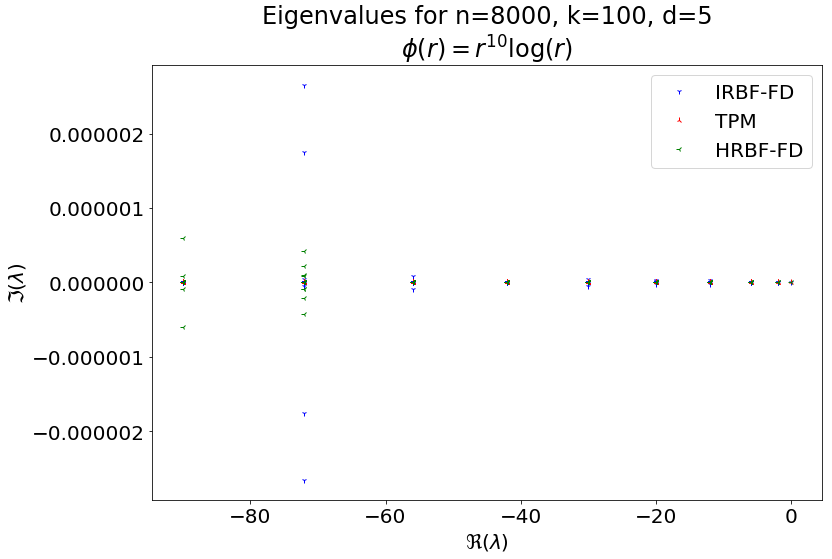

In [64]:
styles = ['b1', 'r2', 'g3', 'k4', 'yx', 'm^', 'cv']
fig = plt.figure(figsize=(12,8))
for eig, style in zip(eigs, styles):
    plt.plot(eig.real, eig.imag, style)
    
plt.legend(legend)
    
plt.title(title)
# plt.minorticks_off()
plt.xlabel('$\Re(\lambda)$')
plt.ylabel('$\Im(\lambda)$')
plt.show()

# Testing

In [13]:
method = 'SWM'
surface = 'T'
n = 16000
k = 50
rbf_obj = rbf_dict['r^10 log(r)']
epsilon = None
poly_type = 'p'
poly_deg = 4

# foo, exact = get_exact('gaussians')
# node_set = 'icos'
# nodes = gen_spiral_nodes(n)
# normals = nodes
# fs = np.array([foo(node) for node in nodes])
# ds = np.array([exact(node) for node in nodes])

nodes, normals = torus_phyllotaxis_points(n)
fs, ds = torus_forcing(nodes)

C = get_weights(method, surface, node_set, n, k, nodes, normals, rbf_obj, 
                epsilon, poly_type, poly_deg)

In [14]:
print(la.norm(C@fs - ds)/la.norm(ds))
print(np.max(np.abs(C@fs - ds)))

0.007547509576960117
10.720902901913497


In [ ]:
spla.eigs(C, k=1, which='LR')[0][0]

# Saved Runs